# Elements logiciels pour le traitement des données en grande dimension

In [1]:
%matplotlib inline

Un arbre k-d (ou k-d tree, pour k-dimensional tree) est une structure de données de partition de l'espace permettant de stocker des points, et de faire des recherches (recherche par plage, plus proche voisin, etc.) plus rapidement qu'en parcourant linéairement le tableau de points.

Plus précisemement, l'arbre k-d est un arbre binaire dans lequel chaque noeud est un point de dimension k. Chaque noeud non terminal peut être vu comme une génération implicite d'un hyperplan séparateur qui découpe l'espace en deux parties. Les points se trouvant à la gauche de l'hyperplan se retrouvent représentés par le sous-arbre gauche de ce noeud alors que les points se trouvant à la droite de l'hyperplan vont dans le sous-arbre droit. La direction de l'hyperplan est choisie de la manière suivante : Chaque noeud de l'arbre est associé avec des k dimensions, avec l'hyperplan de ce noeud perpandiculaire à la direction de son axe. Ainse, par exemple, si pour une certaine découpe on choisit l'axe "x", tout les points du sous-arbre ayant une valeur "x" inférieure à celle du noeud vont aller dans le sous-arbre de gauche, et les autres points seront dans le droit. Dans un tel cas, l'hyperplan séparateur crée est bien orthogonal à l'axe "x".

### Construction

Sachant qu'il y a beaucoup de manière differentes de choisir des plans séparateurs alignés avec les axes, il y a tout autant de manière de construire des arbres k-d. Nous avons utilisé la méthode suivante :

Au fur et à mesure qu'on s'enfonce dans l'arbre, les axes choisis pour sélectioner les plans séparateurs sont alternés de manière cyclique. Par exemple dans le cas où k = 3, la racine aurait un plan séparateur selon "x", alors que ses enfants serait séparés par "y", ses petit-enfants par "z" et ses arrières petit-enfants encore par "x" etc.

Les séparation sont faites en choisissant la médiane des points étant séparés, médiane par rapport à la coordonée séparatrice. La médiane étant une fonction holistique (il est nécessaire de connaître toutes les données avant de la calculer). Cela peut compliquer l'implémentation sur des données qui serait répartis dans différents clusters. Cependant, l'article de Russell A. Brown montre comment implémenter un tel arbre en utilisant MapReduce. Nous avons donc suivi les instructions données dans l'article afin d'implémenter en Spark l'algorithme permettant de dessiner des arbres k-d.


### Algorithme

L'algorithme décrit dans l'article permet de construire un arbre k-d avec MapReduce dans un temps proportionel à nlogn.
L'algorithme commence par trier les données en utilisant une méthode implémenté dans Spark, "sortByKey". Puis utilise une extension pour trouver la médiane. Il est possible de calculer en parallele les dimensions de toutes les partitions que Spark a crée. Ceci permet alors d'identifier dans quelle partition l'élement médian se trouve et d'obtenir sa valeur. Une fois identifié, l'algorithme est rappellé de manière récursive sur les deux sous-arbres formés grâce à la méthode filter qui permet de filtrer (dans notre cas) les éléments supérieurs à l'élément médian, puis les éléments inférieurs.

Spark permet de ne pas garder l'arbre en mémoire, il garde juste des pointeurs permetants de relier chaque noeud à ses enfants.

## Installation de pyspark

In [3]:
import findspark
sparkHome = "C:/Users/carle/spark/spark-2.2.0-bin-hadoop2.7"
findspark.init(sparkHome)

### Petit essai pour calculer PI

In [4]:
def printSpendTime (startTime) :
    spendTime = time.time() - startTime
    m, s = divmod(spendTime, 60)
    h, m = divmod(m, 60)
    print("--------------------------------------------------")
    print ("-----   Temps écoulé : %dh%02dm%02ds" % (h, m, s))
    print("--------------------------------------------------")
    return

In [5]:
'''
import pyspark
import random
import time

startTime = time.time()

sc = pyspark.SparkContext(appName="Pi")
num_samples = 100000000

def inside(p):     
  x, y = random.random(), random.random()
  return x*x + y*y < 1

count = sc.parallelize(range(0, num_samples)).filter(inside).count()

pi = 4 * count / num_samples
print(pi)

sc.stop()

printSpendTime(startTime)
'''

'\nimport pyspark\nimport random\nimport time\n\nstartTime = time.time()\n\nsc = pyspark.SparkContext(appName="Pi")\nnum_samples = 100000000\n\ndef inside(p):     \n  x, y = random.random(), random.random()\n  return x*x + y*y < 1\n\ncount = sc.parallelize(range(0, num_samples)).filter(inside).count()\n\npi = 4 * count / num_samples\nprint(pi)\n\nsc.stop()\n\nprintSpendTime(startTime)\n'

## Arbre k-d classique

### Création d'un jeu de données

In [6]:
import numpy as np
import pandas

n = 10
data = pandas.DataFrame(np.random.rand(n,2)*100,  columns = ['X', 'Y'])
data.iloc[0:10, ]

,X,Y
0,80.418391,68.340912
1,99.726300,96.067207
2,66.011910,74.659447
3,99.431980,78.699092
4,11.124589,55.940270
5,81.849934,58.902719
6,38.148722,26.851984
7,99.626186,95.216601
8,81.729751,51.309552
9,37.467341,3.560072


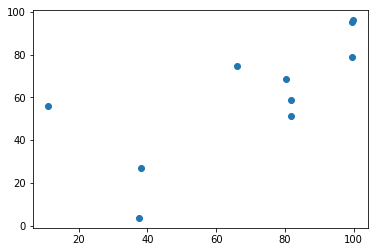

In [7]:
import matplotlib.pyplot as plt

plt.plot(data[['X']], data[['Y']], 'o')
plt.show()

### Définition d'une structure de données pour les arbres binaires

In [8]:
### Classe permettant de definir un arbre binaire simple
### Il se constitue d'un noeud racine, de deux sous-arbres
### et des donnees correspondant au noeud racine
class Tree(object) :
    
    ## Constructeur simple
    def __init__(self) :
        self.left = None
        self.right = None
        self.key = None
        self.data = None
    
    ## Reprensation de l'arbre sous forme de chaine
    ## de caracteres
    def __str__(self) :
        return self.strRec(0)
    
    ## Represente l'arbre sous forme de chaine de caracteres
    ## de facon recursive
    def strRec(self, depth) :
        line = "-" * 3 * depth
        res = line + str(self.data)
        if self.left :
            res += "\n" + self.left.strRec(depth+1)
        if self.right :
            res += "\n" + self.right.strRec(depth+1)
        return res

In [9]:
import matplotlib.pyplot as plt
import matplotlib.lines as lines

### Trace un arbre k-d (classe 'Tree') de facon recursive
def pltTreeRec(ax, tree, keyX, keyY, xLim, yLim) :
    if tree :
        x, y = tree.data[keyX], tree.data[keyY]
        if tree.key == keyX :
            pltTreeRec(ax, tree.left, keyX, keyY, (xLim[0], x), yLim)
            pltTreeRec(ax, tree.right, keyX, keyY, (x, xLim[1]), yLim)
            ax.add_line(lines.Line2D((x, x), yLim, linewidth=0.5, color='red'))
        elif tree.key == keyY :
            pltTreeRec(ax, tree.left, keyX, keyY, xLim, (yLim[0], y))
            pltTreeRec(ax, tree.right, keyX, keyY, xLim, (y, yLim[1]))
            ax.add_line(lines.Line2D(xLim, (y, y), linewidth=0.5, color='red'))
        plt.plot(x, y, 'o', color='#1f77b4')

### Trace un jeu de donnees et l'arbre k-d associe.
### Le parametre 'tree' doit etre une instance de la 
### classe 'Tree'
def plotDataTree(data, tree) :
    colList = data.columns.values.tolist()
    keyX, keyY = colList[0], colList[1]
    ax = plt.axes()
    plt.plot(data[['X']], data[['Y']], 'o', color='#1f77b4')
    xLim, yLim = ax.get_xlim(), ax.get_ylim()
    pltTreeRec(ax, tree, keyX, keyY, xLim, yLim)
    plt.show()

### Algorithme "naïf" pour constituer un arbre k-d

<p>
On propose une première implémentation, "naïve", pour la constitution d'un arbre k-d. Le principe : on découpe de façon cyclique selon les différentes dimension ; à chaque étape on recherche la médiane du tableau (donc une opération de tri) selon la dimension courante ; on lui attache deux sous-arbres correspondants aux valeurs inférieures (resp. supérieures) à la médiane.
</p>
<p>
D'après Bentley, si on est en mesure de trouver la médiane en $O(n)$, la complexité de l'algorithme est en $O(n\log(n))$.
</p>

In [10]:
### Fonction recursive pour constituer un arbre k-d
def arbreKDnaifRec (data, colList, curCol) :
    nCol = len(colList)
    nRow = data.shape[0]
    sortCol = colList[curCol]
    if nRow == 0 :
        return None
    elif nRow == 1 :
        dataNode = data.iloc[0,]
        rootNode = Tree()
        rootNode.key = sortCol
        rootNode.data = dict()
        for col in colList :
            rootNode.data[col] = dataNode[col].item()
        return rootNode
    median = int(nRow / 2)
    if nRow % 2 == 1 :
        median = int((nRow-1) / 2)
    nextCol = (curCol + 1) % nCol
    #if nextCol > nCol :
    #    nextCol = 0
    dataSort = data.sort_values(by=sortCol)
    dataNode = dataSort.iloc[median,]
    rootNode = Tree()
    rootNode.key = sortCol
    rootNode.data = dict()
    for col in colList :
        rootNode.data[col] = dataNode[col].item()
    rootNode.left = arbreKDnaifRec(dataSort.iloc[0:median,], colList, nextCol)
    rootNode.right = arbreKDnaifRec(dataSort.iloc[(median+1):nRow,], colList, nextCol)
    return rootNode

### Fonction englobante permettant la construction d'un arbre k-d
def arbreKDnaif (data) :
    colList = data.columns.values.tolist()
    curCol = 0
    return(arbreKDnaifRec(data, colList, curCol))

{'X': 81.72975110491329, 'Y': 51.3095518443625}
---{'X': 11.124588609380892, 'Y': 55.94026972065363}
------{'X': 38.14872234093515, 'Y': 26.85198352379644}
---------{'X': 37.467341482536284, 'Y': 3.5600721045252026}
------{'X': 80.418391339322, 'Y': 68.34091239069467}
---------{'X': 66.01190992228014, 'Y': 74.65944699559874}
---{'X': 99.62618615209576, 'Y': 95.21660119536529}
------{'X': 99.4319798611382, 'Y': 78.69909239521007}
---------{'X': 81.84993446730964, 'Y': 58.90271887043076}
------{'X': 99.72630005317107, 'Y': 96.06720704548695}


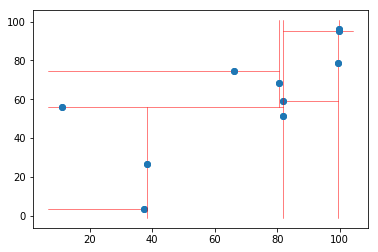

In [11]:
### Test de la fonction 'arbreKDnaif' sur le 
### jeu de donnees 'data'
arbre = arbreKDnaif(data)
print(arbre)
plotDataTree(data, arbre)

### Construction d'un arbre k-d avec pré-tri par dimension

<p>
On implémente, toujours de façon non distribuée, un algorithme de construction d'un arbre k-d où le tri selon les différentes dimension du jeu de données est fait en amont.
</p>

In [12]:
### Fonction recursive pour constituer un arbre k-d
def arbreKDpretriRec (sortedData, colList, curCol) :
    nCol = len(colList)
    sortCol = colList[curCol]
    curData = sortedData[sortCol]
    nRow = curData.shape[0]
    if nRow == 0 :
        return None
    elif nRow == 1 :
        dataNode = curData.iloc[0,]
        rootNode = Tree()
        rootNode.key = sortCol
        rootNode.data = dict()
        for col in colList :
            rootNode.data[col] = dataNode[col].item()
        return rootNode
    median = int(nRow / 2)
    if nRow % 2 == 1 :
        median = int((nRow-1) / 2)
    nextCol = (curCol + 1) % nCol
    dataNode = curData.iloc[median,]
    rootNode = Tree()
    rootNode.key = sortCol
    rootNode.data = dict()
    for col in colList :
        rootNode.data[col] = dataNode[col].item()
    leftSortedData = dict()
    rightSortedData = dict()
    for col in colList :
        leftSortedData[col] = sortedData[col][sortedData[col][sortCol]<rootNode.data[sortCol]]
        rightSortedData[col] = sortedData[col][sortedData[col][sortCol]>rootNode.data[sortCol]]
    rootNode.left = arbreKDpretriRec(leftSortedData, colList, nextCol)
    rootNode.right = arbreKDpretriRec(rightSortedData, colList, nextCol)
    return rootNode

### Fonction englobante permettant la construction d'un arbre k-d
def arbreKDpretri (data) :
    colList = data.columns.values.tolist()
    sortedData = dict()
    for col in colList :
        sortedData[col] = data.sort_values(by = col)
    curCol = 0
    return(arbreKDpretriRec(sortedData, colList, curCol))

{'X': 81.72975110491329, 'Y': 51.3095518443625}
---{'X': 11.124588609380892, 'Y': 55.94026972065363}
------{'X': 38.14872234093515, 'Y': 26.85198352379644}
---------{'X': 37.467341482536284, 'Y': 3.5600721045252026}
------{'X': 80.418391339322, 'Y': 68.34091239069467}
---------{'X': 66.01190992228014, 'Y': 74.65944699559874}
---{'X': 99.62618615209576, 'Y': 95.21660119536529}
------{'X': 99.4319798611382, 'Y': 78.69909239521007}
---------{'X': 81.84993446730964, 'Y': 58.90271887043076}
------{'X': 99.72630005317107, 'Y': 96.06720704548695}


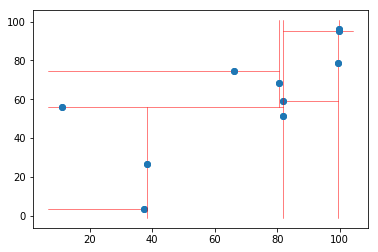

In [13]:
### Test de la fonction 'arbreKDpretri' sur le 
### jeu de donnees 'data'
### --> on doit retrouver le même arbre qu'avec 'arbreKDpretri'
arbre = arbreKDpretri(data)
print(arbre)
plotDataTree(data, arbre)

## Arbre k-d distribué avec Spark

<p>On reprend l'algorithme de constitution d'un arbre k-d avec tri initial selon toutes les dimensions. L'idée est de ne plus charger en mémoire l'intégralité des données, ainsi que l'arbre construit. On utilise pour cela la solution Spark, basée sur les RDD.</p>

In [14]:
### Export du jeu de données au format CSV, pour permettre un traitement général
data.to_csv("data.csv", index=False)

In [15]:
### Chargement du RDD (dans un fichier CSV)
import pyspark
import time

def loadRecord(line, header) :
    values = line.split(",")
    res = dict()
    for i in range(0, len(header)) :
        res[header[i]] = values[i]
    return res

def csvToRdd(sc, file) :
    rddFile = sc.textFile(file)
    rawHeader = rddFile.first()
    header = rawHeader.split(",")
    rddRows = rddFile.filter(lambda l : l != rawHeader).map(lambda l : loadRecord(l, header))
    return rddRows

startTime = time.time()

sc = pyspark.SparkContext(appName="Essai")

rdd = csvToRdd(sc, "data.csv")
print(rdd.count())
print(rdd.take(10))

sc.stop()

printSpendTime(startTime)

10
[{'X': '80.418391339322', 'Y': '68.34091239069467'}, {'X': '99.72630005317107', 'Y': '96.06720704548695'}, {'X': '66.01190992228014', 'Y': '74.65944699559874'}, {'X': '99.4319798611382', 'Y': '78.69909239521007'}, {'X': '11.124588609380892', 'Y': '55.94026972065363'}, {'X': '81.84993446730964', 'Y': '58.90271887043076'}, {'X': '38.14872234093515', 'Y': '26.85198352379644'}, {'X': '99.62618615209576', 'Y': '95.21660119536529'}, {'X': '81.72975110491329', 'Y': '51.3095518443625'}, {'X': '37.467341482536284', 'Y': '3.5600721045252026'}]
--------------------------------------------------
-----   Temps écoulé : 0h00m11s
--------------------------------------------------


In [16]:
test = iter(range(0, 3))
print(next(test))
print(next(test))
print(next(test))
#print(next(test))

0
1
2


In [17]:
import ast
strTup = "('a', 'b', 'c')"
test = ast.literal_eval(strTup)
print(test)
print(test[0])
print(strTup)
print(str(test))
print(str(test)==strTup)

('a', 'b', 'c')
a
('a', 'b', 'c')
('a', 'b', 'c')
True


In [21]:
import pyspark
import time
import numpy as np

def loadRecord(line, header, col) :
    values = line.split(",")
    res = dict()
    for i in range(0, len(header)) :
        res[header[i]] = float(values[i])
    return (res[col], res)

def createRddDict(sc, file) :
    rddFile = sc.textFile(file)
    rawHeader = rddFile.first()
    header = rawHeader.split(",")
    rawRows = rddFile.filter(lambda l : l != rawHeader)
    res = dict()
    for col in header :
        res[col] = rawRows.map(lambda l : loadRecord(l, header, col)).sortByKey()
    return res

def getMedian (rdd_sorted) :
    l = rdd.glom().map(len).collect()  # get length of each partition 

    n = sum(l) #number of elements in all partitions
    median = int(n / 2)
    if n % 2 == 1 :
        median = int((n-1) / 2)
    cumsuml = np.cumsum(l) - median
    filtre = [x for x in cumsuml if x>=0] #filter partition with element smallers than median
    partition_median = len(l)-len(filtre) #partition where the median lye
    
    return(rdd.glom().collect()[partition_median][filtre[0]]) #return the median element (X : Xvalue, Y : Yvalue)


def arbreKDsparkRec (rddDict, colList, curCol, keyIter, outputFile) :
    nCol = len(colList)
    sortCol = colList[curCol]
    curRdd = rddDict[sortCol]
    nRow = curRdd.count()
    if nRow == 0 :
        return (None, (None, None, None))
    elif nRow == 1 :
        res = (next(keyIter), (curRdd.first()[1], None, None))
        with open(outputFile, "a") as fw:
            fw.write(str(res) + "\n")
        return res
    median = getMedian(curRdd)
    print("Mediane : ")
    print(median)
    index = next(keyIter)
    print("Index : ")
    print(index)
    print("Colonne : "+sortCol)
    nextCol = (curCol + 1) % nCol
    leftRddDict = dict()
    rightRddDict = dict()
    for col in colList :
        leftRddDict[col] = rddDict[col].filter(lambda l : l[1][sortCol]<median[sortCol])
        rightRddDict[col] = rddDict[col].filter(lambda l : l[1][sortCol]<median[sortCol])
    left = arbreKDsparkRec(leftRddDict, colList, nextCol, keyIter, outputFile)
    right = arbreKDsparkRec(rightRddDict, colList, nextCol, keyIter, outputFile)
    res = (index, (median, left[0], right[0]))
    with open(outputFile, "a") as fw:
            fw.write(str(res) + "\n")
    return res

def arbreKDspark (sc, inputFile, outputFile) :
    print("--------------------------------------------------")
    print("Constitution d'un arbre KD avec Spark")
    print("Entrée : " + inputFile + " - Sortie : " + outputFile)
    startTime = time.time()
    
    rddDict = createRddDict(sc, inputFile)
    colList = list(rddDict.keys())
    nRow = rddDict[colList[0]].count()
    keyIter = iter(range(0,nRow))
    res = arbreKDsparkRec(rddDict, colList, 0, keyIter, outputFile)
    
    printSpendTime(startTime)
    #return res
    return ""

sc = pyspark.SparkContext(appName="arbreKD")
arbre = arbreKDspark(sc, "data.csv", "arbre.txt")
sc.stop()

--------------------------------------------------
Constitution d'un arbre KD avec Spark
Entrée : data.csv - Sortie : arbre.txt


AttributeError: 'NoneType' object has no attribute 'setCallSite'

In [20]:
sc.stop()

In [24]:
rdd.glom().collect()

AttributeError: 'NoneType' object has no attribute 'setCallSite'